In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
from utils import *

In [57]:
def transform_Z_to_X(Z):
    """
    Transforms a tensor Z of shape (n_mc, n, 4) into X using non-linear transformations.
    Works with both 2D (n, 4) and 3D (n_mc, n, 4) inputs.
    """
    if Z.shape[-1] != 4:
        raise ValueError("Z must have 4 columns in the last dimension")

    # Extract dimensions
    Z1, Z2, Z3, Z4 = Z[..., 0], Z[..., 1], Z[..., 2], Z[..., 3]

    # Apply transformations (vectorized)
    X2 = Z2
    X3 = Z3
    X4 = Z4
    X1 = np.where(Z1 >= 0, Z1**2, -10*np.exp(Z1))

    # Stack along last axis
    X = np.stack((X1, X2, X3, X4), axis=-1)

    return X

def transform_X_to_Z(X):

    if X.shape[-1] != 4:
        raise ValueError("X must have 4 columns in the last dimension")
    
    X1, X2, X3, X4 = X[..., 0], X[..., 1], X[..., 2], X[..., 3]

    Z2 = X2
    Z3 = X3
    Z4 = X4

    Z1 = np.empty_like(X1)  # Create an empty array with the same shape as X1
    Z1[X1 >= 0] = np.sqrt(X1[X1 >= 0])
    Z1[X1 < 0] = np.log(-X1[X1 < 0] / 10)
    
    Z = np.stack((Z1, Z2, Z3, Z4), axis=-1)

    return Z


def generate_X(n, d, corr_rate=0):
    mu = np.zeros(d)
    cov = toep(d,  corr_rate)

    Z = np.random.multivariate_normal(mu, cov, size=n)

    X = transform_Z_to_X(Z)

    return X, Z


import numpy as np
import scipy.stats as stats


def get_y_prob_bayes(X, full_mu, full_cov, true_beta, n_mc=1000, intercept=0):
    """
    Compute Bayesian probability estimates using MCMC samples from the conditional distribution
    of missing variables given observed variables.
    
    Parameters:
    -----------
    X : numpy.ndarray
        Data matrix with missing values as NaN
    full_mu : numpy.ndarray
        Mean vector of the multivariate normal distribution
    full_cov : numpy.ndarray
        Covariance matrix of the multivariate normal distribution
    true_beta : numpy.ndarray
        Coefficient vector for linear model
    n_mc : int, optional
        Number of Monte Carlo samples
    intercept : float, optional
        Intercept term for linear model
        
    Returns:
    --------
    y_probs : numpy.ndarray
        Estimated probabilities
    """
    # Define sigmoid function
    def sigma(x):
        return 1 / (1 + np.exp(-x))
    
    # Get the dimension from the data
    n, d = X.shape
    
    # 1. Make MCMC samples from conditional distribution of Z_mis | Z_obs
    M = np.isnan(X)
    unique_patterns = np.unique(M, axis=0)

    Z = transform_X_to_Z(X)
    
    Z_FULL = np.zeros((n_mc, Z.shape[0], Z.shape[1]))
    
    for pattern in unique_patterns:
        # Find rows with this missing pattern
        row_pattern = np.all(M == pattern, axis=1)
        Z_m = Z[row_pattern]
        
        # If no missing values in this pattern, simply copy the values
        if np.sum(pattern) == 0:
            Z_FULL[:, row_pattern, :] = np.tile(Z_m, (n_mc, 1, 1))
            continue
            
        # Get indices of observed and missing variables for this pattern
        m = pattern  # The pattern itself tells us which values are missing
        observed_idx = ~m
        missing_idx = m
        
        # Extract parameters for conditional distribution
        mu_obs = full_mu[observed_idx]
        mu_mis = full_mu[missing_idx]
        
        cov_obs = full_cov[np.ix_(observed_idx, observed_idx)]
        cov_obs_inv = np.linalg.inv(cov_obs)
        
        cov_mis = full_cov[np.ix_(missing_idx, missing_idx)]
        cross_cov = full_cov[np.ix_(missing_idx, observed_idx)]  # Corrected cross-covariance indexing
        
        # Calculate conditional covariance
        cond_cov = cov_mis - cross_cov @ cov_obs_inv @ cross_cov.T  # Corrected matrix multiplication
        
        # Allocate space for this pattern's imputed values
        z_full_pattern = np.zeros((n_mc, Z_m.shape[0], Z.shape[1]))
        
        # For each row with this pattern
        for i in range(Z_m.shape[0]):
            z_obs = Z_m[i, observed_idx]
            
            # Calculate conditional mean
            cond_mu = mu_mis + cross_cov @ cov_obs_inv @ (z_obs - mu_obs)  # Corrected matrix multiplication
            
            # Generate Monte Carlo samples for missing values
            if len(missing_idx) == 0 or np.sum(missing_idx) == 0:
                z_mis_samples = np.zeros((n_mc, 0))
            else:
                z_mis_samples = np.random.multivariate_normal(cond_mu, cond_cov, size=n_mc)
            
            # Combine observed and imputed values
            for j in range(n_mc):
                z_full_pattern[j, i, observed_idx] = z_obs
                z_full_pattern[j, i, missing_idx] = z_mis_samples[j] if z_mis_samples.size > 0 else []
        
        # Store the imputed values for this pattern
        Z_FULL[:, row_pattern, :] = z_full_pattern
    
    # 2. Transform Z back to X space
    X_FULL = transform_Z_to_X(Z_FULL)
    
    # 3. Compute probabilities using logistic function
    y_logits = np.matmul(X_FULL, true_beta) + intercept
    y_probs = sigma(y_logits)
    
    return y_probs





# --- Running the pipeline ---
n = 10000
cov = 0.99
d = 4

X_full, Z_full = generate_X(n, d, corr_rate=cov)

M = generate_mask(n, d, 0.35)
X = X_full.copy()
X[M==1] = np.nan
Z = Z_full.copy()
Z[M==1] = np.nan

beta = np.random.normal(0, 1, size=4)
y_logits = np.dot(X_full, beta)
y_probs = sigma(y_logits)
y = np.random.binomial(1, y_probs)


mu = np.zeros(d)
cov_matrix = toep(d, cov)





In [58]:
y_probs_bayes100 = get_y_prob_bayes(X[:100], mu, cov_matrix, beta, n_mc=100, intercept=0).mean(axis=0)
y_probs_bayes500 = get_y_prob_bayes(X[:100], mu, cov_matrix, beta, n_mc=500, intercept=0).mean(axis=0)
y_probs_bayes1000 = get_y_prob_bayes(X[:100], mu, cov_matrix, beta, n_mc=1000, intercept=0).mean(axis=0)
y_probs_bayes5000 = get_y_prob_bayes(X[:100], mu, cov_matrix, beta, n_mc=5000, intercept=0).mean(axis=0)


In [59]:
y_probs_bayes10000 = get_y_prob_bayes(X[:100], mu, cov_matrix, beta, n_mc=10000, intercept=0).mean(axis=0)
y_probs_bayes50000 = get_y_prob_bayes(X[:100], mu, cov_matrix, beta, n_mc=50000, intercept=0).mean(axis=0)

In [60]:
print("100: ",np.mean(np.abs(y_probs_bayes100 - y_probs_bayes50000)))
print("500: ",np.mean(np.abs(y_probs_bayes500 - y_probs_bayes50000)))
print("1000: ",np.mean(np.abs(y_probs_bayes1000 - y_probs_bayes50000)))
print("5000: ",np.mean(np.abs(y_probs_bayes5000 - y_probs_bayes50000)))
print("10000: ",np.mean(np.abs(y_probs_bayes10000 - y_probs_bayes50000)))

100:  0.0035716575543296093
500:  0.0016766030459851608
1000:  0.0008652063006049124
5000:  0.0005487092852149041
10000:  0.00031825605783294053


In [ ]:
# 100:  0.0024951761172773645
# 500:  0.001002318519664983
# 1000:  0.000795803049617921
# 5000:  0.00031891525416349626
# 10000:  0.0002881337195022337

# 100:  0.002605254080471544
# 500:  0.0012331422870760222
# 1000:  0.0008338838048598052
# 5000:  0.0003097028960175136
# 10000:  0.0002448481380207473

# 100:  0.002199079071002961
# 500:  0.000865699015053186
# 1000:  0.0008079185839174008
# 5000:  0.00037569944467571894
# 10000:  0.00022538361516389848

# 100:  0.0024166394346805476
# 500:  0.0008889507061289582
# 1000:  0.0007658144803129097
# 5000:  0.00025464381323655224
# 10000:  0.0002526892400668919

# 100:  0.0035716575543296093
# 500:  0.0016766030459851608
# 1000:  0.0008652063006049124
# 5000:  0.0005487092852149041
# 10000:  0.00031825605783294053

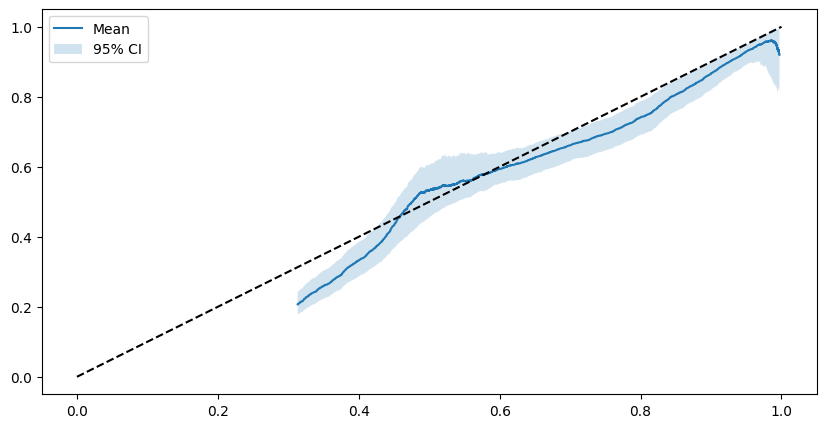

In [26]:
y_probs_low = np.percentile(y_probs_bayes, 2.5, axis=0)
y_probs_high = np.percentile(y_probs_bayes, 97.5, axis=0)
y_probs_mean = np.mean(y_probs_bayes, axis=0)

sort_idx = np.argsort(y_probs)

k = 500

plt.figure(figsize=(10, 5))
plt.plot(y_probs[sort_idx], pd.Series(y_probs_mean[sort_idx]).rolling(k).mean(), label="Mean")
plt.fill_between(y_probs[sort_idx], pd.Series(y_probs_low[sort_idx]).rolling(k).mean(), pd.Series(y_probs_high[sort_idx]).rolling(k).mean(), alpha=0.2, label="95% CI")
plt.plot([0, 1], [0, 1], color="black", linestyle="--") 
plt.legend()
plt.show()

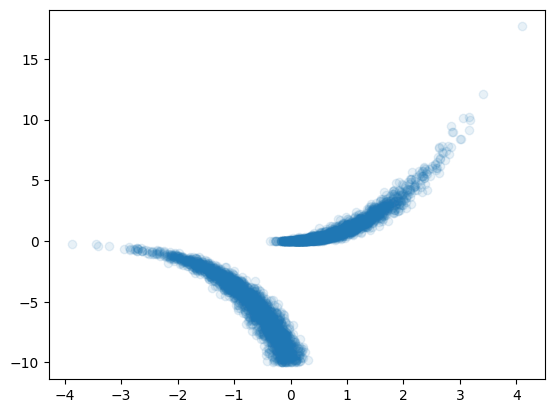

In [27]:
id = 0
# plt.scatter(Z_full[:,id], X_full[:,id], alpha=0.1);
plt.show()
plt.scatter(X[:,1], X[:,0], alpha=0.1);

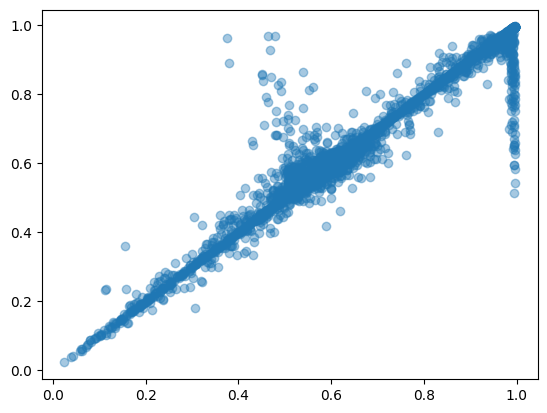

In [28]:
idx = get_index_pattern(1,  M)
plt.scatter(y_probs[idx], y_probs_bayes.mean(axis=0)[idx], alpha=0.4);

In [104]:
# Define the percentages of missingness and number of replicates

experiment_name = "ExpD"
experiment_data_folder = os.path.join("data", experiment_name)

if os.path.exists(experiment_data_folder) == False:
    os.makedirs(experiment_data_folder)

if os.path.exists(os.path.join(experiment_data_folder, "original_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "original_data"))

if os.path.exists(os.path.join(experiment_data_folder, "test_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "test_data"))

if os.path.exists(os.path.join(experiment_data_folder, "pred_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "pred_data"))

if os.path.exists(os.path.join(experiment_data_folder, "bayes_data")) == False:
    os.makedirs(os.path.join(experiment_data_folder, "bayes_data"))


missingness_percentages = [0.35]
n_replicates = 2
Ds = [4]
Corrs = [0.70, 0.95, 0.99]
n_train = 100000
n_test = 15000
n = n_train + n_test

print("# of setups = ", n_replicates * len(missingness_percentages) * len(Corrs))

N_MC = 3000

# The set-up dataframe should contain:
# - rep
# - n
# - trueProp1
# - true_beta
# - center_X
# - set_up (name)
# [The rest will be part of **kwargs throughout the code]

df_set_up = pd.DataFrame({
    "rep":[],
    "n":[],
    "true_beta": [],
    "set_up": [],
    "d":[],
    "corr":[],
    "prcNA": [],
}).T

np.random.seed(1)
random.seed(1)

for rep in range(n_replicates):
    print("REP", rep)
    for d in Ds:

        beta0 = np.random.normal(0, 1.0, d)

        for corr in Corrs:

            corr_str = str(corr).replace(".", "")
                
            X_full, Z_full = generate_X(n, d, corr_rate=corr)
            y_probs = sigma(X_full @ beta0)
            y = np.random.binomial(n=1, p=y_probs)
            
            for prc in missingness_percentages:

                prc_str = str(prc).replace(".", "")
                set_up = f"LOG_n{n}_d{d}_corr{corr_str}_prcNA{prc_str}_rep{rep}"

                M = generate_mask(n, d, prc) # don't allow fully missing
                
                X_obs = X_full.copy()
                X_obs[M == 1] = np.nan


                new_row = pd.Series({
                    "rep":rep,
                    "n":n,
                    "d":d,
                    "corr":corr,
                    "prcNA":prc,
                    "true_beta":beta0,
                    "set_up":set_up
                })

                df_set_up = pd.concat([df_set_up, new_row], axis=1, ignore_index=True)

                data_to_save = {
                    "X_obs": X_obs,
                    "M": M,
                    "y": y,
                    "y_probs": y_probs,
                    "X_full": X_full
                }

                # save
                np.savez(os.path.join(experiment_data_folder, "original_data", f"{set_up}.npz"), **data_to_save)

                # test data
                X_test = X_obs[n_train:]
                y_test = y[n_train:]
                y_probs_test = y_probs[n_train:]
                M_test = M[n_train:]
                data_to_save_test = {
                    "X_obs": X_test,
                    "M": M_test,
                    "y": y_test,
                    "y_probs": y_probs_test,
                    "X_full": X_full[n_train:]
                }
                np.savez(os.path.join(experiment_data_folder, "test_data", f"{set_up}.npz"), **data_to_save_test)

                # bayes
                full_mu = np.zeros(d)
                full_cov = toep(d, corr)
                y_probs_bayes = get_y_prob_bayes(X_test, full_mu, full_cov, beta0, n_mc=N_MC, intercept=0)
                y_probs_bayes = y_probs_bayes.mean(axis=0)

                data_to_save_bayes = {
                    "y_probs_bayes": y_probs_bayes
                }

                np.savez(os.path.join(experiment_data_folder, "bayes_data", f"{set_up}.npz"), **data_to_save_bayes)


                    
# save df set-up
df_set_up.T.to_csv(os.path.join(experiment_data_folder, "set_up.csv"), index=False)

# of setups =  6
REP 0
(15000,)
(15000,)
(15000,)
REP 1
(15000,)
(15000,)
(15000,)


In [ ]:
# # Recompute the Bayes probs

# import time

# # Load the set-up

# df_set_up = pd.read_csv(os.path.join("data", "ExpD", "set_up.csv"))

# for i in range(df_set_up.shape[0]):

#     print("Current time: ", time.ctime())

#     set_up = df_set_up.loc[i, "set_up"]
#     print(set_up)

#     X_test = load_data(set_up, "test", "ExpD")["X_obs"]
#     full_mu = np.zeros(X_test.shape[1])
#     full_cov = toep(df_set_up.loc[i, "d"], df_set_up.loc[i, "corr"])
#     beta0 = df_set_up.loc[i, "true_beta"]
#     beta0 = beta0.strip("[]").split()
#     beta0 = [float(x) for x in beta0]
#     y_probs_bayes = get_y_prob_bayes(X_test, full_mu, full_cov, beta0, n_mc=500, intercept=0).mean(axis=0)

#     data_to_save_bayes = {
#         "y_probs_bayes": y_probs_bayes
#     }

#     np.savez(os.path.join("data", "ExpD", "bayes_data", f"{set_up}.npz"), **data_to_save_bayes)


Current time:  Mon Feb 24 14:26:15 2025
LOG_n115000_d4_corr07_prcNA035_rep0
Current time:  Mon Feb 24 14:26:55 2025
LOG_n115000_d4_corr095_prcNA035_rep0
Current time:  Mon Feb 24 14:27:36 2025
LOG_n115000_d4_corr099_prcNA035_rep0
Current time:  Mon Feb 24 14:28:33 2025
LOG_n115000_d4_corr07_prcNA035_rep1
Current time:  Mon Feb 24 14:29:20 2025
LOG_n115000_d4_corr095_prcNA035_rep1
Current time:  Mon Feb 24 14:30:08 2025
LOG_n115000_d4_corr099_prcNA035_rep1
